# Common Pool Resource with Single Agent

In [1]:
using MultiAgentEmergence
using POMDPs
using POMDPPolicies
using POMDPSimulators
using POMDPModelTools

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("/Users/liamsmith/.julia/packages/Plots/5kcBO/src/backends/unicodeplots.jl", 77, UndefVarError(:UserColorType)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00000001004322cf, Ptr{Nothing} @0x00000001004c62a1, Ptr{Nothing} @0x000000010ba12d52, Ptr{Nothing} @0x00000001004b0fbf, Ptr{Nothing} @0x00000001004c825f, Ptr{Nothing} @0x00000001004c6b94, Ptr{Nothing} @0x00000001004c6f0c, Base.InterpreterIP in top-level CodeInfo for Plots at statement 3, Ptr{Nothing} @0x00000001004e1844, Ptr{Nothing} @0x00000001004e1604, Ptr{Nothing} @0x00000001004e2134, Ptr{Nothing} @0x000000010bddb4e7, Ptr{Nothing} @0x00000001004b0fbf, Ptr{Nothing} @0x000000010be2c312, Ptr{Nothing} @0x000000010ba62a65, Ptr{Nothing} @0x00000001004b0fbf, Ptr{Nothing} @0x00000001004bd839, Ptr{Nothing} @0x000000010946aa2e, Ptr{Nothing} @0x00000001004b0fbf, Ptr{Nothing} @0x00000001004c825f, Ptr{Nothing} @0x00000001004c6b94, Ptr{Nothing} @0x00

In [2]:
# Global Settings
hr = HistoryRecorder(max_steps = 1000)
pomdp = CommonPool()
map = DefaultMap(pomdp)
POMDPs.initialstate_distribution(m::CommonPool) = Deterministic(map)
episodes = 50

50

## Random Policy
Move in random direction

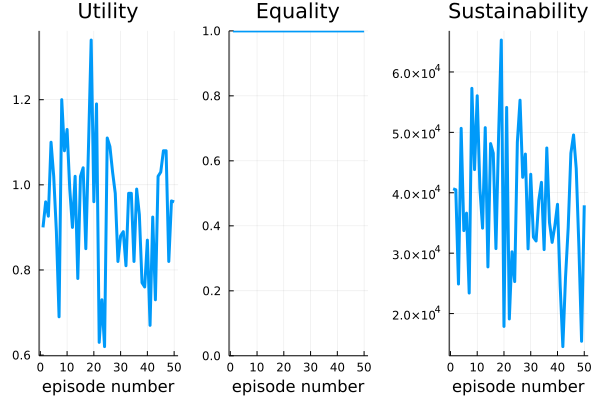

In [3]:
policy_random = random_policy
harray_random = []
for i in 1:episodes 
    push!(harray_random, simulate(hr, pomdp, policy_random))
end
plot_socials(harray_random)

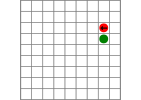

In [4]:
# Gif of one episode
ep_num = rand(1:length(harray_random))
h = harray_random[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

# This would work if render returns a plot object from Plots.jl
#@gif for (s, a, r, sp) in eachstep(h)
#    render(mdp, (s=s,a=a))
#end

## Greedy Policy
Move in direction of most resources (observation range radius: 3)

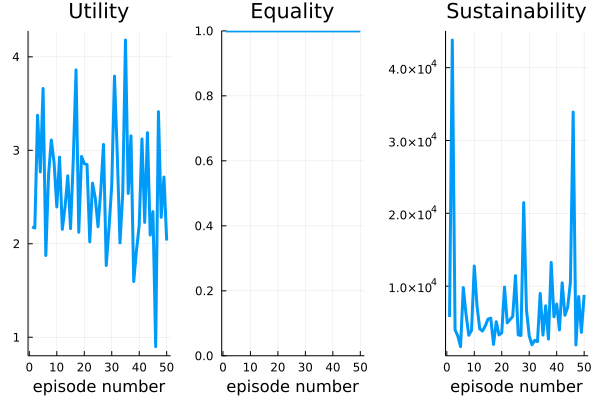

In [5]:
obs_range = 3
POMDPs.observation(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)
policy_greedy = greedy_policy
harray_greedy = []
for i in 1:episodes 
    push!(harray_greedy, simulate(hr, pomdp, policy_greedy))
end
plot_socials(harray_greedy)

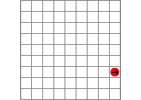

In [6]:
# Gif of one episode
ep_num = rand(1:length(harray_greedy))
h = harray_greedy[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

## Path Policy
Follow predefined path

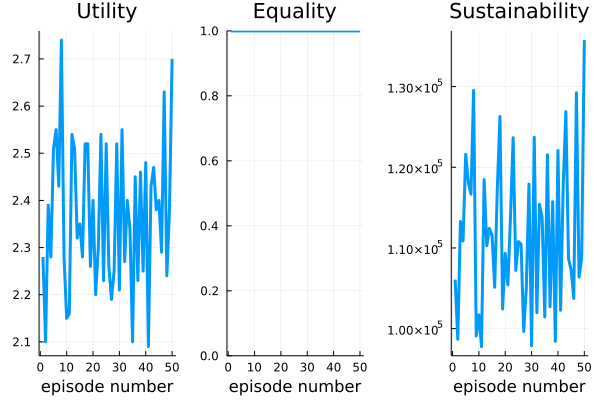

In [7]:
policy_path = path_policy(pomdp,map)
harray_path = []
for i in 1:episodes 
    push!(harray_path, simulate(hr, pomdp, policy_path))
    policy_path = path_policy(pomdp,map) # reset the path each iteration
end
plot_socials(harray_path)

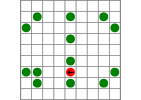

In [8]:
# Gif of one episode
ep_num = rand(1:length(harray_path))
h = harray_path[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

## DQN Policy

In [9]:
using DeepQLearning
using Flux

In [10]:
obs_range = 3
POMDPs.observation(m::CommonPool, s::CommonPoolState) = POMDPs.observation(m, s, obs_range)

#DQN
model = Chain(Dense(49, 32), Dense(32, length(actions(pomdp))))
exploration = EpsGreedyPolicy(pomdp, LinearDecaySchedule(start=1.0, stop=0.01, steps=10000/2))
solver = DeepQLearningSolver(qnetwork = model, max_steps=10000, 
                             exploration_policy = exploration,
                             learning_rate=0.005,log_freq=1000,
                             recurrence=false,double_q=true, dueling=true, prioritized_replay=true)
policy_dqn = solve(solver, pomdp)

Evaluation ... Avg Reward 161.10 | Avg Step 101.00 
 1000 / 10000 eps 0.802 |  avgR 166.364 | Loss 3.977e+00 | Grad 2.887e-01 | EvalR 161.100 
Evaluation ... Avg Reward 255.80 | Avg Step 101.00 
Evaluation ... Avg Reward 209.00 | Avg Step 101.00 
 2000 / 10000 eps 0.604 |  avgR 205.714 | Loss 2.638e+00 | Grad 3.144e-01 | EvalR 209.000 
Evaluation ... Avg Reward 231.00 | Avg Step 101.00 
Evaluation ... Avg Reward 236.30 | Avg Step 101.00 
 3000 / 10000 eps 0.406 |  avgR 225.484 | Loss 2.328e+00 | Grad 1.449e-01 | EvalR 236.300 
Evaluation ... Avg Reward 294.00 | Avg Step 101.00 
Saving new model with eval reward 294.000 
Evaluation ... Avg Reward 321.30 | Avg Step 100.95 
 4000 / 10000 eps 0.208 |  avgR 242.195 | Loss 3.198e+00 | Grad 4.769e-01 | EvalR 321.300 
Evaluation ... Avg Reward 258.00 | Avg Step 101.00 
Evaluation ... Avg Reward 275.50 | Avg Step 100.83 
 5000 / 10000 eps 0.010 |  avgR 247.647 | Loss 2.698e+00 | Grad 5.201e-01 | EvalR 275.500 
Evaluation ... Avg Reward 327.80 |

NNPolicy{CommonPool, DeepQLearning.DuelingNetwork, Symbol}(CommonPool(9, 9, Dict(:left => 2, :right => 1, :up => 4, :down => 3), 10, 0.9), DeepQLearning.DuelingNetwork(Chain(), Chain(Dense(49, 32), Dense(32, 1)), Chain(Dense(49, 32), Dense(32, 4))), [:up, :down, :left, :right], 1)

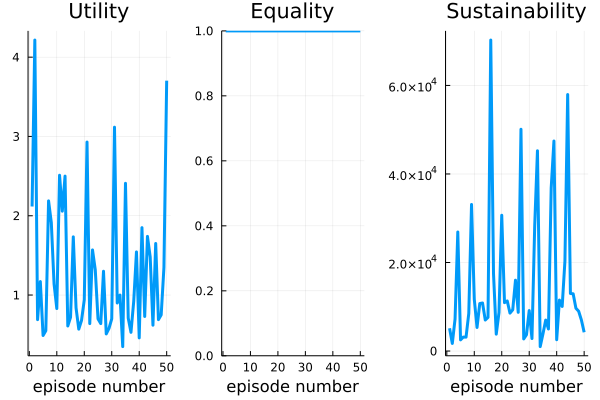

In [11]:
harray_dqn = []
for i in 1:episodes 
    push!(harray_dqn, simulate(hr, pomdp, policy_dqn))
end
plot_socials(harray_dqn)

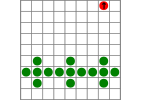

In [12]:
# Gif of one episode
ep_num = rand(1:length(harray_dqn))
h = harray_dqn[ep_num]
for (s, a, sp) in eachstep(h)
    IJulia.clear_output(true)
    display(render(pomdp, (s=sp,a=a)))
    sleep(1/60) # 60 fps
end

## Compare Policies

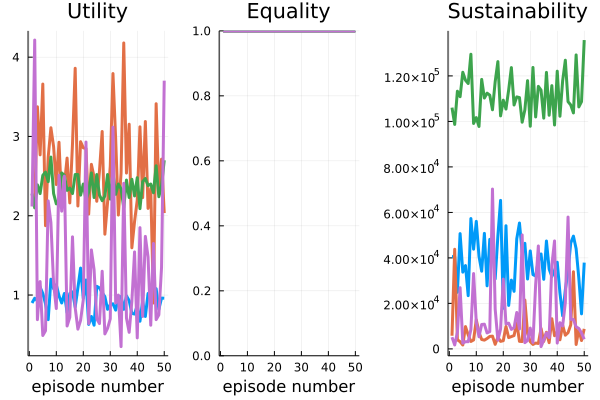

In [13]:
p1 = plot_socials(harray_random)       # blue
p2 = plot_socials!(p1, harray_greedy)  # red
p3 = plot_socials!(p2, harray_path)    # green
p4 = plot_socials!(p3, harray_dqn)     # purple